# Code to create a simple flat sky simulation of the Compton-y noise spectrum

In [1]:
import numpy as np, sys, os, warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%load_ext autoreload
%autoreload 2

#%pylab notebook
%matplotlib inline
from pylab import *
cmap = cm.RdYlBu_r

In [2]:
rcParams['figure.dpi'] = 150
rcParams["figure.facecolor"] = 'white'

In [3]:
#get params for sim generation
boxsize_arcmins, dx = 120., 0.5 #arcminutes
cl_file = '2112.07656/ilc_weights_residuals/ilc_weights_residuals.npy'
expname = 'S4-Wide'

In [4]:
#get ra, dec or map-pixel grid
nx = int(boxsize_arcmins/dx)
mapparams = [nx, nx, dx, dx]
x1,x2 = -nx/2. * dx, nx/2. * dx

ra_for_grid = np.linspace(x1,x2, nx)/60.
dec_for_grid = np.linspace(x1,x2, nx)/60.
ra_grid, dec_grid = np.meshgrid(ra_for_grid,dec_for_grid)

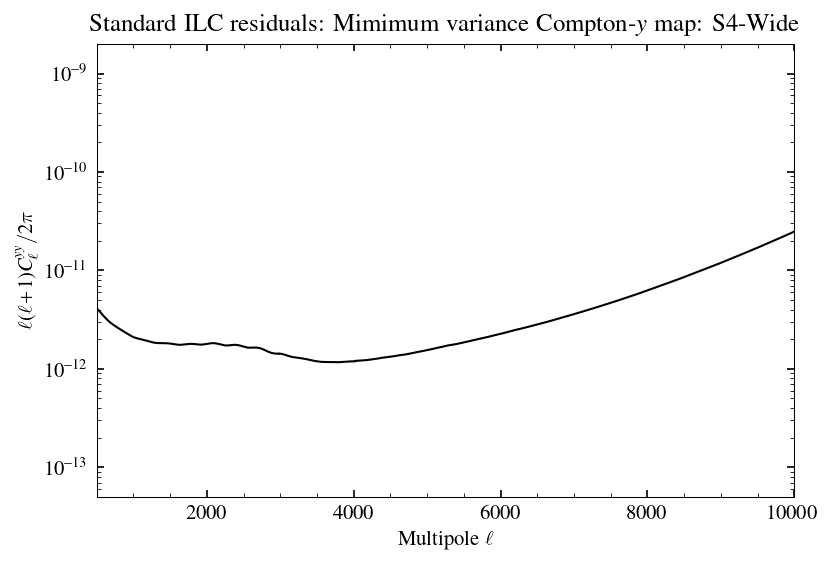

In [5]:
#read Cls now
ilc_dict = np.load(cl_file, allow_pickle = True).item()
els = ilc_dict['els']
nl_yy = ilc_dict['ilc_residuals'][expname]
if (1):
    dl_fac = els * (els+1)/2/np.pi
    ax = subplot(111, yscale = 'log')
    plot(els, nl_yy * dl_fac)
    xlim(500, 10000)
    ylim(5e-14, 2e-9)
    xlabel(r'Multipole $\ell$')
    ylabel(r'$\ell (\ell+1) C_{\ell}^{yy}/2 \pi$')
    title(r'Standard ILC residuals: Mimimum variance Compton-$y$ map: %s' %(expname))
    show()    

In [6]:
def get_lxly(flatskymapparams):
    ny, nx, dx = flatskymapparams
    dx = np.radians(dx/60.)

    lx, ly = np.meshgrid( np.fft.fftfreq( nx, dx ), np.fft.fftfreq( ny, dx ) )
    lx *= 2* np.pi
    ly *= 2* np.pi

    return lx, ly

def cl_to_cl2d(el, cl, flatskymapparams):
    lx, ly = get_lxly(flatskymapparams)
    ell = np.sqrt(lx**2. + ly**2.)
    cl2d = np.interp(ell.flatten(), el, cl, left = 0., right = 0.).reshape(ell.shape)
    return cl2d

def make_gaussian_realisation(mapparams, el, cl, cltwod = None, bl = None):

    ny, nx, dx = mapparams
    arcmins2radians = np.radians(1/60.)

    dx *= arcmins2radians

    ################################################
    #map stuff
    norm = np.sqrt(1./ (dx**2.))
    ################################################

    #if cltwod is given, directly use it, otherwise do 1d to 2d
    if cltwod is None:
        cltwod = cl_to_cl2d(el, cl, mapparams)

    cltwod = cltwod**0.5 * norm
    cltwod[np.isnan(cltwod)] = 0.

    gauss_reals = np.random.standard_normal([nx,ny])
    #print(gauss_reals[0,0], cl[20:23]); 
    SIM = np.fft.ifft2( np.copy( cltwod ) * np.fft.fft2( gauss_reals ) ).real

    #add beam
    if bl is not None:
        if np.ndim(bl) != 2:
            bl = cl_to_cl2d(el, bl, mapparams)
        SIM = np.fft.ifft2( np.fft.fft2(SIM) * bl).real

    #remove mean
    SIM = SIM - np.mean(SIM)

    return SIM

def map2cl(flatskymapparams, flatskymap1, flatskymap2 = None, binsize = None, mask = None, filter_2d = None):

    """
    map2cl module - get the power spectra of map/maps

    input:
    flatskymyapparams = [ny, nx, dx] where ny, nx = flatskymap.shape; and dx is the pixel resolution in arcminutes.
    for example: [100, 100, 0.5] is a 50' x 50' flatskymap that has dimensions 100 x 100 with dx = 0.5 arcminutes.

    flatskymap1: map1 with dimensions (ny, nx)
    flatskymap2: provide map2 with dimensions (ny, nx) cross-spectra

    binsize: el bins. computed automatically if None

    cross_power: if set, then compute the cross power between flatskymap1 and flatskymap2

    output:
    auto/cross power spectra: [el, cl, cl_err]
    """

    ny, nx, dx = flatskymapparams
    dx_rad = np.radians(dx/60.)

    lx, ly = get_lxly(flatskymapparams)

    if binsize == None:
        binsize = lx.ravel()[1] -lx.ravel()[0]

    if flatskymap2 is None:
        flatskymap_psd = abs( np.fft.fft2(flatskymap1) * dx_rad)** 2 / (nx * ny)
    else: #cross spectra now
        assert flatskymap1.shape == flatskymap2.shape
        flatskymap_psd = np.fft.fft2(flatskymap1) * dx_rad * np.conj( np.fft.fft2(flatskymap2) ) * dx_rad / (nx * ny)

    rad_prf = radial_profile(flatskymap_psd, (lx,ly), bin_size = binsize, minbin = 100, maxbin = 10000, to_arcmins = 0)
    el, cl = rad_prf[:,0], rad_prf[:,1]

    if mask is not None:
        fsky = np.mean(mask)
        cl /= fsky

    if filter_2d is not None:
        rad_prf_filter_2d = radial_profile(filter_2d, (lx,ly), bin_size = binsize, minbin = 100, maxbin = 10000, to_arcmins = 0)
        el, fl = rad_prf_filter_2d[:,0], rad_prf_filter_2d[:,1]
        cl /= fl

    return el, cl

################################################################################################################

def radial_profile(z, xy = None, bin_size = 1., minbin = 0., maxbin = 10., to_arcmins = 1):

    """
    get the radial profile of an image (both real and fourier space)
    """

    z = np.asarray(z)
    if xy is None:
        x, y = np.indices(image.shape)
    else:
        x, y = xy

    #radius = np.hypot(X,Y) * 60.
    radius = (x**2. + y**2.) ** 0.5
    if to_arcmins: radius *= 60.

    binarr=np.arange(minbin,maxbin,bin_size)
    radprf=np.zeros((len(binarr),3))

    hit_count=[]

    for b,bin in enumerate(binarr):
        ind=np.where((radius>=bin) & (radius<bin+bin_size))
        radprf[b,0]=(bin+bin_size/2.)
        hits = len(np.where(abs(z[ind])>0.)[0])

        if hits>0:
            radprf[b,1]=np.sum(z[ind])/hits
            radprf[b,2]=np.std(z[ind])
        hit_count.append(hits)

    hit_count=np.asarray(hit_count)
    std_mean=np.sum(radprf[:,2]*hit_count)/np.sum(hit_count)
    errval=std_mean/(hit_count)**0.5
    radprf[:,2]=errval

    return radprf

(240, 240)


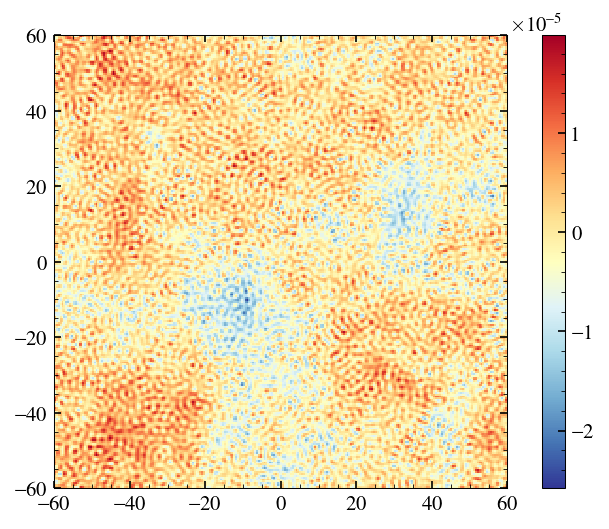

In [7]:
#create a Gaussian realisation now using the above power spectrum
mapparams = [nx, nx, dx]
mock_compton_yy_noise = make_gaussian_realisation(mapparams, els, nl_yy)
print(mock_compton_yy_noise.shape)
imshow(mock_compton_yy_noise, cmap = cmap, extent=[x1, x2, x1, x2]); colorbar(); show()

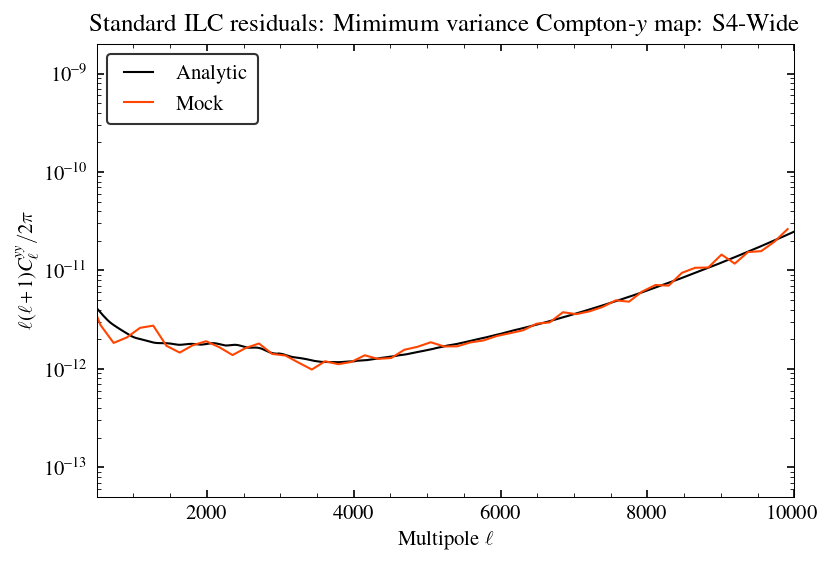

In [8]:
#make sure the above sim power spectrum matches the input
binned_els, binned_nl_yy = map2cl(mapparams, mock_compton_yy_noise)
if (1):
    dl_fac = els * (els+1)/2/np.pi
    dl_fac_binned = binned_els * (binned_els+1)/2/np.pi
    ax = subplot(111, yscale = 'log')
    plot(els, nl_yy * dl_fac, label = r'Analytic')
    plot(binned_els, binned_nl_yy * dl_fac_binned, color = 'orangered', label = r'Mock')
    xlim(500, 10000)
    ylim(5e-14, 2e-9)
    xlabel(r'Multipole $\ell$')
    ylabel(r'$\ell (\ell+1) C_{\ell}^{yy}/2 \pi$')
    legend(loc = 2)
    title(r'Standard ILC residuals: Mimimum variance Compton-$y$ map: %s' %(expname))
    show()  